In [ ]:
# default_exp capsAnalaysis

In [ ]:
import sys

In [ ]:
sys.path.append('/workspace/oct_ca_seg/oct/')

In [ ]:
from oct.startup import *
from model import CapsNet
import numpy as np
import mlflow
from fastai.vision import *
import mlflow.pytorch as MLPY
from fastai.utils.mem import gpu_mem_get_all
from skimage import filters

In [ ]:
gpu_mem_get_all()

In [ ]:
cocodata_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = cocodata_path/'train/images'
valid_path = cocodata_path/'valid/images'
test_path = cocodata_path/'test/images'

In [ ]:
metrics = [sens, spec, dice, my_Dice_Loss, acc]

In [ ]:
runsave_dir = Path('/workspace/oct_ca_seg/runsaves/')

In [ ]:
run_name = 'UNET_0001_30_' 
cfg_file = 'configUNET_APPresnet18_bs16_epochs15_lr0.001.json'

In [ ]:
run_name = 'UNET_0001_30_final' 
cfg_file = 'configUNET_APPresnet18_bs16_epochs15_lr0.001.json'

In [ ]:
run_dir = runsave_dir/run_name

In [ ]:
def loadConfigRun(run_dir, name):
    with open(run_dir/name, 'r') as file:
        return json.load(file)

In [ ]:
cfg_dict = loadConfigRun(run_dir, cfg_file)

In [ ]:
config = DeepConfig(cfg_dict)

In [ ]:
cfg_dict

## Train, Valid

In [64]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(cocodata_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_folder('train', 'valid')
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size=config.LEARNER.img_size)
data = src.databunch(cocodata_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
data.normalize(stats);
data.c_in, data.c_out = 3, 2

## Test

In [16]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(test_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images')
       .split_by_rand_pct(0.90)
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size =config.LEARNER.img_size)
data = src.databunch(test_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
#stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
stats = data.batch_stats()
data.normalize(stats);
data.c_in, data.c_out = 3, 2

## Load Model

In [ ]:
deepCap = CapsNet(config.MODEL).cuda()
learn = Learner(data = data,
                  model = deepCap,
                  metrics = metrics)

In [17]:
unet = unet_learner(data, models.resnet18, pretrained=False, metrics = metrics)

### LR finder

In [66]:
lr_find(unet)

epoch,train_loss,valid_loss,sens,spec,dice,my_Dice_Loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


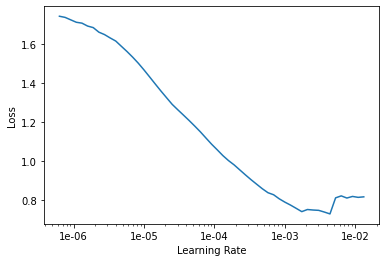

In [67]:
unet.recorder.plot()

## Run Analysis

In [18]:
unet = unet.load(run_dir/'learner')

In [19]:
unet.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________

In [20]:
class Analysis():
    def __init__(self, learner:Learner, run_dir:Path):
        self.learner = learner
        self.run_dir = run_dir
        self.metrics = pd.read_json(self.run_dir/'metrics.json')
        self.trainL =  pd.read_json(self.run_dir/'trainL.json')
        self.validL =  pd.read_json(self.run_dir/'validL.json')
    
    def remove0FromMetric(self, metric):
        zero_dict = {k:v for (k,v) in self.results[metric].items() if v==0}
        zero_dict = {k: v for k, v in sorted(zero_dict.items(), key=lambda item: item[1])}
        new_dict = {k:v for (k,v) in self.results[metric].items() if v!=0}
        new_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
        print('there were ', len(zero_dict.keys()), 'zeros in the ', metric,' list.')
        return zero_dict, new_dict
    
    def histPlotMetric(self, metric, save=False):
        #metric = one of 'dices', 'sens', 'specs', 'accs' 
        zeros, actual = self.remove0FromMetric(metric)
        l_actual = list(actual.values())
        l_actual = [x for x in l_actual if x==x] # get rid of nans
        mean, std, median, max, min = np.mean(l_actual), np.std(l_actual), np.median(l_actual), np.max(l_actual), np.min(l_actual)
        print(mean, std, median, max, min)
        plt.hist(l_actual)
        if save: plt.savefig(self.checkpoint_path/(metric+'.png'))
        #return l_actual
    
    def showPrediction(self, id):
        self.learner.model.eval()
        batch = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=False, detach=True, cpu=False)
        img = self.learner.data.one_batch(ds_type=DatasetType.Valid, denorm=True, detach=True, cpu=True)[0]
        xb = batch[0][id]#.permute(1,2,0).cpu()
        yb = batch[1][id][0]#.permute(1,2,0).cpu()
        pb = self.learner.model(xb.unsqueeze(0).cuda())[0]
        #print(xb.size(), yb.size(), pb.size())
        fig, (axim, axl, axp) = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5),
                    subplot_kw={'xticks': [], 'yticks': []})
        #images
        im = axim.imshow(img[id].permute(1,2,0))
        axim.set_title('Image')
        l = axl.imshow(yb.cpu())
        axl.set_title('Label')
        p = axp.imshow(torch.argmax(pb.detach().cpu(), dim=0))
        print()
        axp.set_title('Pred')
        
        #return xb.size(), yb.size(), pb.size()

In [21]:
asis = Analysis(unet, run_dir)

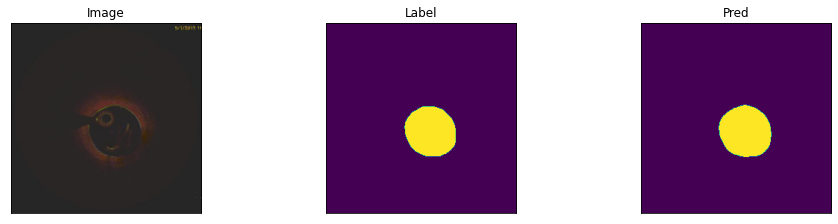

In [40]:
asis.showPrediction(0)

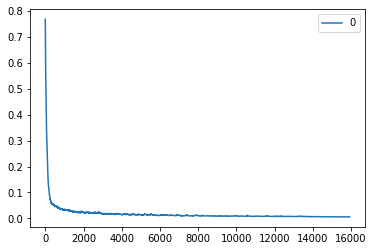

In [41]:
asis.trainL.sort_index().plot.line()

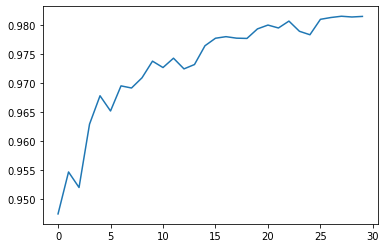

In [42]:
asis.metrics['dice'].sort_index().plot.line()

In [23]:
asis.metrics;

## test loop

In [22]:
xb,yb=data.one_batch(denorm=False,cpu=True)

In [23]:
unet.model.cpu()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [24]:
xb.size()

torch.Size([16, 3, 256, 256])

In [25]:
%%time 
pb = unet.model(xb)

CPU times: user 26.7 s, sys: 3.75 s, total: 30.4 s
Wall time: 1.11 s


In [26]:
!cat /proc/cpuinfo | grep processor | wc -l	

28


In [29]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              28
On-line CPU(s) list: 0-27
Thread(s) per core:  1
Core(s) per socket:  14
Socket(s):           2
NUMA node(s):        2
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU E5-2680 v4 @ 2.40GHz
Stepping:            1
CPU MHz:             1200.138
CPU max MHz:         3300.0000
CPU min MHz:         1200.0000
BogoMIPS:            4800.17
Virtualization:      VT-x
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            35840K
NUMA node0 CPU(s):   0-13
NUMA node1 CPU(s):   14-27
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm ibrs flush_l1d md_clear constant_tsc arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc aperfmperf eagerfpu pn

In [21]:
%%time
preds,targs = unet.get_preds()

CPU times: user 11 s, sys: 4.03 s, total: 15 s
Wall time: 15.8 s


In [38]:
preds.size(), targs.size()

(torch.Size([909, 2, 256, 256]), torch.Size([909, 1, 256, 256]))

In [58]:
preds.nelement()*preds.element_size()#/1024/1024

476577792

In [22]:
%%time
recorder = []
for p,y in iter(zip(preds,targs)): 
    p = p.unsqueeze(0)
    y = y.unsqueeze(0)
    recorder.append([met(p, y).item() for met in metrics])

CPU times: user 38min 31s, sys: 5.52 s, total: 38min 37s
Wall time: 1min 22s


In [23]:
test_results = pd.DataFrame(recorder, columns=[met.__name__ for met in unet.metrics])

In [24]:
test_results.mean(axis=0)

sens            0.941674
spec            0.996027
dice            0.967723
my_Dice_Loss    0.880063
acc             0.035721
dtype: float64

In [25]:
test_results.std(axis=0)

sens            0.080560
spec            0.006467
dice            0.054236
my_Dice_Loss    0.029518
acc             0.000000
dtype: float64

In [26]:
test_results.median(axis=0)

sens            0.961967
spec            0.997580
dice            0.980615
my_Dice_Loss    0.878570
acc             0.035721
dtype: float64

In [27]:
test_results.min(axis=0)

sens            0.363106
spec            0.932740
dice            0.532763
my_Dice_Loss    0.796850
acc             0.035721
dtype: float64

In [28]:
test_results.max(axis=0)

sens            0.988690
spec            0.999420
dice            0.994313
my_Dice_Loss    0.945615
acc             0.035721
dtype: float64

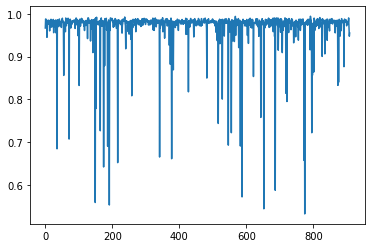

In [32]:
test_results['dice'].plot.line()

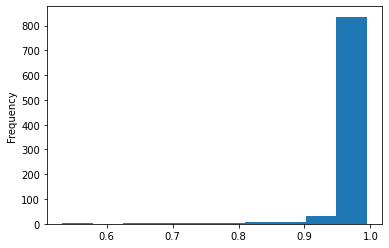

In [30]:
test_results['dice'].plot.hist()

In [31]:
test_results.to_json(run_dir/'test_results.json')

In [33]:
test_results.sort_values(by='dice')

,sens,spec,dice,my_Dice_Loss,acc
774,0.363106,0.962550,0.532763,0.895839,0.035721
652,0.374295,0.961936,0.544708,0.892859,0.035721
191,0.382732,0.962608,0.553588,0.892041,0.035721
149,0.388347,0.964791,0.559438,0.897695,0.035721
587,0.401022,0.932740,0.572471,0.800501,0.035721
...,...,...,...,...,...
819,0.982711,0.998564,0.991280,0.848445,0.035721
153,0.984119,0.998943,0.991996,0.886085,0.035721
237,0.985183,0.999008,0.992536,0.885369,0.035721
567,0.988035,0.999238,0.993981,0.888774,0.035721


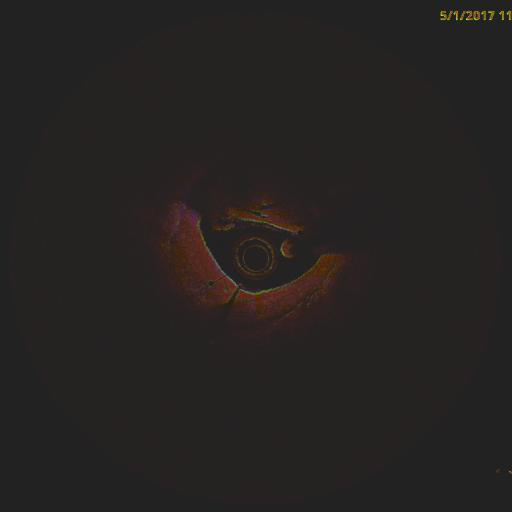

In [34]:
unet.data.valid_ds.x[774]

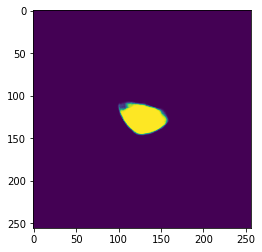

In [35]:
plt.imshow(preds[774][1])

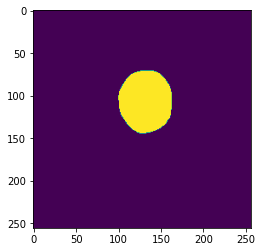

In [36]:
plt.imshow(targs[774][0])

In [166]:
learn.validate(metrics=metrics)

[0.31771377,
 tensor(0.9490),
 tensor(0.9965),
 tensor(0.9725),
 tensor(-4.5412),
 tensor(0.9404)]

In [ ]:
def freeze_to(learn, n): # freeze model up to layer n
    for i, param in enumerate(learn.model.parameters()):
        if i<n: param.requires_grad=False

In [ ]:
learn.unfreeze()

In [ ]:
freeze_to(learn, 60)

In [ ]:
for i, param in enumerate(learn.model.parameters()):
    print(i,param.requires_grad)

In [ ]:
learn.opt.clear()

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(0.00001), wd=0.01, pct_start=0.3)

In [60]:
!git add .

In [61]:
!git commit . -m 'seemingly better but i think this unet is overfitted'

[master 5a2a36e] seemingly better but i think this unet is overfitted
 Committer: Arjun Balaji <abalaji@a082-mgmt.pawsey.org.au>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly. Run the
following command and follow the instructions in your editor to edit
your configuration file:

    git config --global --edit

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 29 files changed, 3074 insertions(+), 678 deletions(-)
 delete mode 100644 02a_capsAnalysis.ipynb
 create mode 100644 03a_capsAnalysis.ipynb
 create mode 100644 03a_unetAnalysis.ipynb
 rename 03_validateD2.ipynb => 888_validateD2.ipynb (100%)
 create mode 100644 DEEEPCAP4688037.out
 create mode 100644 DEEEPCAP4688303.out
 create mode 100644 DEEEPCAP4688399.out
 create mode 100644 DEEEPCAP4688636.out
 create mode 100644 DEEEPCAP4688